### Import Libraries

In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, TargetEncoder
from sklearn.linear_model import Lasso
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import joblib

### Import Dataset

In [497]:
df = pd.read_csv("Salary_Data.csv")

In [498]:
print(df.head())

    Age  Gender Education Level          Job Title  Years of Experience  \
0  32.0    Male      Bachelor's  Software Engineer                  5.0   
1  28.0  Female        Master's       Data Analyst                  3.0   
2  45.0    Male             PhD     Senior Manager                 15.0   
3  36.0  Female      Bachelor's    Sales Associate                  7.0   
4  52.0    Male        Master's           Director                 20.0   

     Salary  
0   90000.0  
1   65000.0  
2  150000.0  
3   60000.0  
4  200000.0  


### Check for null values

In [499]:
print(df.isnull().values.any())
print(df.isnull().sum())

True
Age                    2
Gender                 2
Education Level        3
Job Title              2
Years of Experience    3
Salary                 5
dtype: int64


### Imputing

In [500]:
num_cols = ["Age","Years of Experience","Salary"]
cat_cols = ["Gender", "Education Level", "Job Title"]

imputer = SimpleImputer(strategy="mean")
df[num_cols] = imputer.fit_transform(df[num_cols])
imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = imputer.fit_transform(df[cat_cols])

In [501]:
print(df.isnull().values.any())
print(df.isnull().sum())

False
Age                    0
Gender                 0
Education Level        0
Job Title              0
Years of Experience    0
Salary                 0
dtype: int64


### Remove "Degree" from Education Level

In [502]:
df["Education Level"] = df["Education Level"].str.replace('degree','', case=False).str.strip()
df["Education Level"] = df["Education Level"].str.replace('phD','PhD', case=True).str.strip()

### Split Features from the Independent Variable

In [503]:
X = df.iloc[:, :-1]
y = df.iloc[:,-1]

### Create Pipeline

In [504]:
num_transformer = StandardScaler()
cat_transformer = OneHotEncoder(handle_unknown="ignore", drop="first")
job_transformer = TargetEncoder()

num_features = ["Age", "Years of Experience"]
cat_features = ["Gender", "Education Level"]
job_features = ["Job Title"]

preprocessor = ColumnTransformer(
    transformers=[
        ("numeric", num_transformer, num_features),
        ("categorical", cat_transformer, cat_features),
        ("job", job_transformer, job_features)
    ]
)

joblib.dump(preprocessor, "salary_preprocessor.joblib")

['salary_preprocessor.joblib']

In [505]:
pipeline = Pipeline(steps=[("preprocessor", preprocessor), ("model", Lasso(alpha=0.5))])
joblib.dump(pipeline, "salary_pipeline.joblib")

['salary_pipeline.joblib']

### Splitting the Training Set and Test Set

In [506]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

In [507]:
print(X_train)
print(X_test)
print(y_train)
print(y_test)

       Age  Gender Education Level                  Job Title  \
586   25.0  Female      Bachelor's               Data Analyst   
6180  30.0  Female      Bachelor's      Marketing Coordinator   
4146  28.0  Female      Bachelor's      Marketing Coordinator   
1715  44.0  Female             PhD  Software Engineer Manager   
2574  54.0    Male        Master's   Senior Software Engineer   
...    ...     ...             ...                        ...   
3915  39.0  Female        Master's          Marketing Manager   
1428  27.0  Female        Master's        Full Stack Engineer   
6537  25.0  Female     High School            Sales Executive   
4367  28.0  Female      Bachelor's  Junior Software Developer   
2522  31.0  Female        Master's        Full Stack Engineer   

      Years of Experience  
586                   2.0  
6180                  5.0  
4146                  2.0  
1715                 11.0  
2574                 31.0  
...                   ...  
3915                 11

### Create the Model and Fit to Training Data All With Pipeline

In [508]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric', StandardScaler(),
                                                  ['Age',
                                                   'Years of Experience']),
                                                 ('categorical',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Gender',
                                                   'Education Level']),
                                                 ('job', TargetEncoder(),
                                                  ['Job Title'])])),
                ('model', Lasso(alpha=0.5))])

### Predict on the Test Data

In [509]:
y_pred = pipeline.predict(X_test)

In [510]:
print(y_pred)

[ 98282.95616195 180208.72158068 156447.59811941 ...  72601.65285136
 102761.85013078  38664.99687252]


In [511]:
print(y_test)

3405     95000.0
2245    195000.0
5420    160000.0
6169    120000.0
1474    180000.0
          ...   
4618     90000.0
334      95000.0
2035     65000.0
6439     55000.0
3758     35000.0
Name: Salary, Length: 1341, dtype: float64


### Change this to a better format

In [512]:
y_test_series = pd.Series(y_test)
y_pred_series = pd.Series(y_pred)

In [513]:
print(y_test_series)
print(y_pred_series)

3405     95000.0
2245    195000.0
5420    160000.0
6169    120000.0
1474    180000.0
          ...   
4618     90000.0
334      95000.0
2035     65000.0
6439     55000.0
3758     35000.0
Name: Salary, Length: 1341, dtype: float64
0        98282.956162
1       180208.721581
2       156447.598119
3       127155.997579
4       167559.002381
            ...      
1336     90750.915523
1337    119340.575770
1338     72601.652851
1339    102761.850131
1340     38664.996873
Length: 1341, dtype: float64


### Create a DataFrame for Comparison

In [514]:
comparison_df = pd.concat([y_test_series.reset_index(drop=True), y_pred_series], axis=1)
comparison_df.columns = ["Actual", "Predicted"]

print(comparison_df)

        Actual      Predicted
0      95000.0   98282.956162
1     195000.0  180208.721581
2     160000.0  156447.598119
3     120000.0  127155.997579
4     180000.0  167559.002381
...        ...            ...
1336   90000.0   90750.915523
1337   95000.0  119340.575770
1338   65000.0   72601.652851
1339   55000.0  102761.850131
1340   35000.0   38664.996873

[1341 rows x 2 columns]


### Evaluate the Model

In [515]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test_series.values, y_pred_series.values)
rmse = np.sqrt(mean_squared_error(y_test_series.values, y_pred_series.values))
mae = mean_absolute_error(y_test_series.values, y_pred_series.values)
r2 = r2_score(y_test_series.values, y_pred_series.values)


In [516]:
print("Mean Squared Error: ", mse)
print("Root Mean Squared Error: ", rmse)
print("Mean Absolute Error: ", mae)
print("R-Squared Score: ", r2)

Mean Squared Error:  554836220.2910384
Root Mean Squared Error:  23554.961691563803
Mean Absolute Error:  17516.792121135455
R-Squared Score:  0.8057918125755091


### Visualize Actual vs. Predicted

Text(0.5, 1.0, 'Actual vs. Predicted Values')

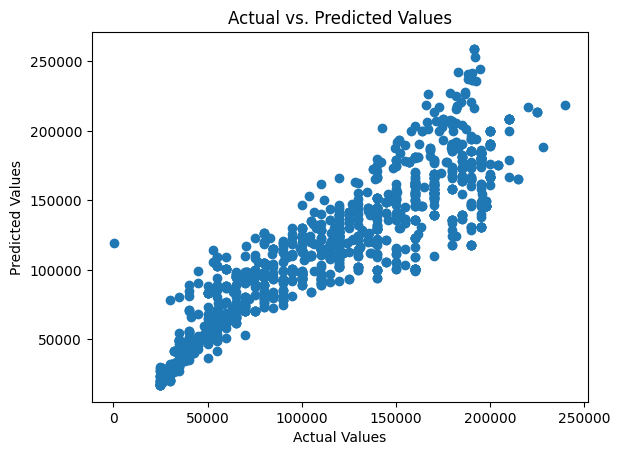

In [517]:
plt.scatter(y_test_series.values, y_pred_series.values)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")

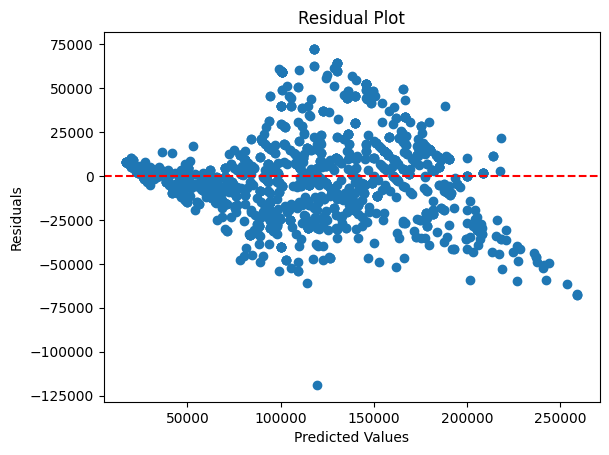

In [518]:

residuals = y_test_series.values - y_pred_series.values
plt.scatter(y_pred_series.values, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

### Testing New Data

In [519]:
new_data = {
    "Age" : [23],
    "Gender" : ["Male"],
    "Education Level": ["Bachelor's"],
    "Job Title": ["Junior Software Engineer"],
    "Years of Experience": [1],
}

new_df = pd.DataFrame(new_data)

encoded_features = preprocessor.named_transformers_["categorical"].get_feature_names_out()


In [520]:
print(new_df)
print(encoded_features)

   Age Gender Education Level                 Job Title  Years of Experience
0   23   Male      Bachelor's  Junior Software Engineer                    1
['Gender_Female' 'Gender_Male' 'Gender_Other' "Education Level_Bachelor's"
 'Education Level_High School' "Education Level_Master's"
 'Education Level_PhD']


In [521]:
for feature in encoded_features: 
    new_df[feature] = 0


In [522]:
print(new_df)


   Age Gender Education Level                 Job Title  Years of Experience  \
0   23   Male      Bachelor's  Junior Software Engineer                    1   

   Gender_Female  Gender_Male  Gender_Other  Education Level_Bachelor's  \
0              0            0             0                           0   

   Education Level_High School  Education Level_Master's  Education Level_PhD  
0                            0                         0                    0  


In [523]:
new_pred = pipeline.predict(new_data_transformed)

ValueError: X has 13 features, but ColumnTransformer is expecting 5 features as input.